In [1]:
import scanpy as sc

In [2]:
import sc_aautils as scaa
import itertools as it
from pandarallel import pandarallel

In [3]:
import Colors

# output directory

In [4]:
outdir = '../trackerseq_analysis/'
os.system('mkdir -p '+outdir)

0

# Read data

In [5]:
t1rep1_gex = read_csv('/Users/cupida/Desktop/noelle_projects/CerebralOrganoids/hashtag_exp1/lineage_fromGEX/202201213_GEX_cbc_bc_umi_cell_cnt.tsv.gz', sep = '\t', header = None, names = ['lin','umi','cell','cnt'])
t1rep1_nes = read_csv('/Users/cupida/Desktop/noelle_projects/CerebralOrganoids/hashtag_exp1/lineage_fastq/nested_amplificaiton/202201213_nested_lineage_20_L004_cbc_bc_umi_cell_cnt.tsv.gz', sep = '\t', header = None, names = ['lin','umi','cell','cnt'])

In [6]:
t1rep2_gex = read_csv('/Users/cupida/Desktop/noelle_projects/CerebralOrganoids/hashtag_exp4/lineage_fromGEX/T1_2_H9_GEX_cbc_bc_umi_cell_cnt.tsv.gz', sep = '\t', header = None, names = ['lin','umi','cell','cnt'])
t1rep2_nes = read_csv('/Users/cupida/Desktop/noelle_projects/CerebralOrganoids/hashtag_exp4/lineage_fromNESTED/T1_2_H9_Lineage_cbc_bc_umi_cell_cnt.tsv.gz', sep = '\t', header = None, names = ['lin','umi','cell','cnt'])

In [7]:
t2rep1_gex = read_csv('/Users/cupida/Desktop/noelle_projects/CerebralOrganoids/hashtag_exp5/lineage_fromGEX/202303415_GEX_cbc_bc_umi_cell_cnt.tsv.gz', sep = '\t', header = None, names = ['lin','umi','cell','cnt'])
t2rep1_nes = read_csv('/Users/cupida/Desktop/noelle_projects/CerebralOrganoids/hashtag_exp5/lineage_fromNESTED/202303415_lineage_cbc_bc_umi_cell_cnt.tsv.gz', sep = '\t', header = None, names = ['lin','umi','cell','cnt'])


# Organise data in dictionary

In [8]:
lindata = {'t1rep1': {'gex': t1rep1_gex, 'nested': t1rep1_nes}, 
          't1rep2': {'gex': t1rep2_gex, 'nested': t1rep2_nes}
          #'t2rep1': {'gex': t2rep1_gex, 'nested': t2rep1_nes}
          }
           

# Create lineage tables

In [9]:
def reduceLineageBarcodeSequence(df):
    barcode = 'CTGA..CTG..ACT..GAC..TGA..CTG..ACT..GAC..GACT'
    lin_pos = [i for i, (li, lb) in enumerate(zip(df['lin'].iloc[0], barcode)) if lb == '.']
    df['lin'] = df['lin'].apply(lambda x: ''.join([li for i, (li, lb) in enumerate(zip(x, barcode)) if lb == '.']))
    return df
  

In [10]:
def lineage_coutb_tables(df):
    cdf = {c: {l: len(df_l) for l, df_l in df_c.groupby('lin')} for c, df_c in df[['lin','umi','cell']].groupby('cell')}
    cdf = pd.DataFrame(cdf).fillna(0).astype(int)
    cdf = cdf.loc[cdf.sum(axis=1).sort_values(ascending=False).index]
    
    return cdf
    

In [11]:
def lineage_coutc_tables(df):
    cdf = {c: {l: df_l['cnt'].sum() for l, df_l in df_c.groupby('lin')} for c, df_c in df.groupby('cell')}
    cdf = pd.DataFrame(cdf).fillna(0).astype(int)
    cdf = cdf.loc[cdf.sum(axis=1).sort_values(ascending=False).index]
    return cdf

In [12]:
def lineage_umi_tables(df):
    cdf = pd.DataFrame({c: {l: df_l[['umi','cnt']].set_index('umi').to_dict()['cnt'] for l, df_l in df_c.groupby('lin')} for c, df_c in df.groupby('cell')})
    return cdf

In [13]:
for time in lindata:
    for strategy in lindata[time]:
        lindata[time][strategy] = reduceLineageBarcodeSequence(lindata[time][strategy])

In [14]:
lindata_coutb = {time: {strat: lineage_coutb_tables(lindata[time][strat]) for strat in lindata[time]} for time in lindata}

In [15]:
for time in lindata:
    for strategy in lindata[time]:
        print(time, strategy, len(lindata_coutb[time][strategy].columns), len(lindata_coutb[time][strategy]))

t1rep1 gex 3924 1029
t1rep1 nested 5457 7851
t1rep2 gex 4556 289
t1rep2 nested 4661 5328


In [16]:
lindata_coutc = {time: {strat: lineage_coutc_tables(lindata[time][strat]) for strat in lindata[time]} for time in lindata}

In [17]:
lindata_umi = {time: {strat: lineage_umi_tables(lindata[time][strat]) for strat in lindata[time]} for time in lindata}

In [18]:
time = 't1rep1'; strat = 'nested'
lindata_umi[time][strat].loc[lindata_coutc[time][strat].index].head()

,AAACCCATCACGGTCG,AAACGAAAGGGTAATT,AAACGAAGTAAGCGGT,AAACGAAGTATGCGTT,AAACGAAGTCCATAGT,AAACGAAGTCGTGCCA,AAACGAATCTTGGGCG,AAACGCTAGAGTGTTA,AAACGCTAGCGCCTCA,AAACGCTAGGCGTCCT,...,TTTGGTTAGTGCTAGG,TTTGGTTCACAGGATG,TTTGGTTCACTTTATC,TTTGGTTGTTCAGTAC,TTTGGTTTCTCTGACC,TTTGTTGAGATCGACG,TTTGTTGAGTACAGAT,TTTGTTGCATGTGGTT,TTTGTTGCATTGCAAC,TTTGTTGTCCTTGACC
CTCATTGTCGTTGAAT,NaN,"{'CCATGGTTAGCT': 1, 'TAACTGAGGATT': 1, 'TCGTAA...","{'GCTGGGATAGTT': 1, 'TAAGTATTCATC': 2, 'TTGGAC...","{'ATCAACGGTTGC': 1, 'TCTGAGGAGCTT': 1, 'TTCAGT...",NaN,NaN,{'TATATAACAGGT': 1},NaN,{'CAGCAGTGAAAC': 1},"{'CTCATCATCGCA': 1, 'CTTCATGATAAA': 1, 'TTCCTC...",...,{'CAGGAACGTACA': 1},NaN,{'TACCTAAAAACC': 2},"{'AAAATCATAACT': 1, 'AGCGTCGACTCT': 1, 'GCTTTT...","{'ACCTCATCCGTT': 1, 'CGCTAATACCGC': 1, 'GTTTTA...","{'AAGAGAAAAGTA': 2, 'GTACAAGTATAA': 1}","{'CCGGTGCAAGGT': 1, 'GGCTCAAATGGC': 3, 'GGGTTA...",NaN,NaN,NaN
TCGTGGATGTCCGATC,NaN,NaN,"{'AAATCACAGTAC': 1, 'CATTGCATTGTA': 1}",NaN,NaN,NaN,"{'CACTACATCAAA': 2, 'TTATCTCGAGGA': 1}",NaN,NaN,"{'AACACCACCTAC': 7, 'AACTGCCGGTCG': 4, 'ACATAC...",...,NaN,NaN,NaN,NaN,NaN,{'TACTCCCACGTT': 1},{'TACCGCATTCAC': 1},{'CGTAAACTCAAC': 1},NaN,NaN
TGGCGAGCGGGGCGTT,{'CTCTGGACACCA': 1},NaN,"{'TAATAGTCGTAA': 4, 'TGAATTTTAACG': 1}",{'CACTATAGCAAT': 3},{'AAAAGTTCTACA': 2},NaN,"{'AGTCCAGCTAGC': 1, 'GCGAGTTCAGAT': 1, 'TCAGAA...",NaN,NaN,NaN,...,NaN,NaN,NaN,"{'CACGCTTTAGTT': 1, 'CGCCATGTGATG': 8}",NaN,NaN,NaN,NaN,NaN,NaN
GATGACCTTTTGGCAT,{'GTCGGACATAAG': 2},NaN,"{'GTGTGACCTGCA': 3, 'TTGCAGAATTAC': 1}","{'GTAGCTAGCCGT': 1, 'TATAGTACACAG': 1}",NaN,NaN,{'ACGAATAAACAT': 1},NaN,NaN,NaN,...,NaN,NaN,{'AATGCGAACCTA': 1},NaN,{'TTAACTCATCGC': 2},NaN,NaN,NaN,NaN,NaN
GGATTCGTCTTTAAGC,NaN,NaN,NaN,NaN,NaN,NaN,"{'CCTGGCAGGTGA': 1, 'GCCCACTACATC': 1}",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,{'TCGCGTAAACTC': 2},NaN,NaN,NaN


In [19]:
cell = 'AAACGAAGTATGCGTT'
for idx in lindata_umi[time][strat].index:
    if type(lindata_umi[time][strat].loc[idx][cell])==dict:
        print(idx, lindata_umi[time][strat].loc[idx][cell])


GATGACCTTTTGGCAT {'GTAGCTAGCCGT': 1, 'TATAGTACACAG': 1}
TGGCGAGCGGGGCGTT {'CACTATAGCAAT': 3}
CTCATTGTCGTTGAAT {'ATCAACGGTTGC': 1, 'TCTGAGGAGCTT': 1, 'TTCAGTGATTGC': 3}


# QC on cells

In [20]:
def mean_overseq(series_of_dics):
    z = [y.values() for y in series_of_dics if type(y)==dict]
    ov = []
    for y in z:
        ov += list(y)
    return np.mean(ov)
        
def max_meanoverseq_per_barcode(series_of_dics):
    z = [y.values() for y in series_of_dics if type(y)==dict]
    ov = []
    for y in z:
        ov += [np.mean(list(y))]
    return np.max(ov)

def lin_barcode_most_overseq(series_of_dics):
    z = [y.values() for y in series_of_dics if type(y)==dict]
    ov = []
    for y in z:
        ov += [np.mean(list(y))]
    return np.where(ov==np.max(ov))

def function_cell_metadata(coutcdf, coutbdf,umidf): 
    odf = pd.DataFrame({
        'read_count': coutcdf.sum(), 
        'umi_count': coutbdf.sum(), 
        'total_linbarcodes': (coutcdf>0).sum(), 
        'total_meanoverseq': umidf.apply(lambda x: mean_overseq(x)),
        'max_overseq': umidf.apply(lambda x: max_meanoverseq_per_barcode(x)),
        'top_linbarcode': umidf.apply(lambda x: umidf.index[lin_barcode_most_overseq(x)][0])
    })
    return odf

In [21]:
cell_metadata = {time: {strat: function_cell_metadata(lindata_coutc[time][strat],lindata_coutb[time][strat].loc[lindata_coutc[time][strat].index], lindata_umi[time][strat].loc[lindata_coutc[time][strat].index]) for strat in lindata_coutc[time]}for time in lindata_coutc}


In [22]:
time = 't1rep1'; strat = 'nested'; cell = 'AAACGAAGTATGCGTT'
cell_metadata[time][strat]#.loc[cell]

,read_count,umi_count,total_linbarcodes,total_meanoverseq,max_overseq,top_linbarcode
AAACCCATCACGGTCG,4,3,3,1.333333,2.000000,TCGTGGATGTCCGATC
AAACGAAAGGGTAATT,19,13,7,1.461538,4.000000,TGGCGAGCGGGGCGTT
AAACGAAGTAAGCGGT,22,13,7,1.692308,2.500000,TGGCGAGCGGGGCGTT
AAACGAAGTATGCGTT,10,6,3,1.666667,3.000000,TCGTGGATGTCCGATC
AAACGAAGTCCATAGT,2,1,1,2.000000,2.000000,CTCATTGTCGTTGAAT
...,...,...,...,...,...,...
TTTGTTGAGATCGACG,3766,50,15,75.320000,110.264706,GATGACCTTTTGGCAT
TTTGTTGAGTACAGAT,12,7,5,1.714286,3.000000,GATGACCTTTTGGCAT
TTTGTTGCATGTGGTT,1,1,1,1.000000,1.000000,CTCATTGTCGTTGAAT
TTTGTTGCATTGCAAC,2,2,2,1.000000,1.000000,CTCATTGTCGTTGAAT


In [23]:
time = 't1rep1'; strat = 'gex'; cell = 'AAACGAAGTATGCGTT'
cell_metadata[time][strat]#.loc[cell]

,read_count,umi_count,total_linbarcodes,total_meanoverseq,max_overseq,top_linbarcode
AAACCCAAGCGATGAC,3,1,1,3.000000,3.000000,CTCATTGTCGTTGAAT
AAACCCATCACGGTCG,2,2,1,1.000000,1.000000,CTCATTGTCGTTGAAT
AAACGAAAGGGTAATT,2,2,1,1.000000,1.000000,CTCATTGTCGTTGAAT
AAACGAAGTATGCGTT,2,1,1,2.000000,2.000000,CTCATTGTCGTTGAAT
AAACGAAGTCGTGCCA,1,1,1,1.000000,1.000000,CTCATTGTCGTTGAAT
...,...,...,...,...,...,...
TTTGTTGAGATCGACG,39,7,1,5.571429,5.571429,CTCATTGTCGTTGAAT
TTTGTTGAGTACAGAT,1,1,1,1.000000,1.000000,CTCATTGTCGTTGAAT
TTTGTTGCATGTGGTT,5,2,2,2.500000,3.000000,CTCATTGTCGTTGAAT
TTTGTTGCATTGCAAC,3,2,2,1.500000,2.000000,CTCATTGTCGTTGAAT


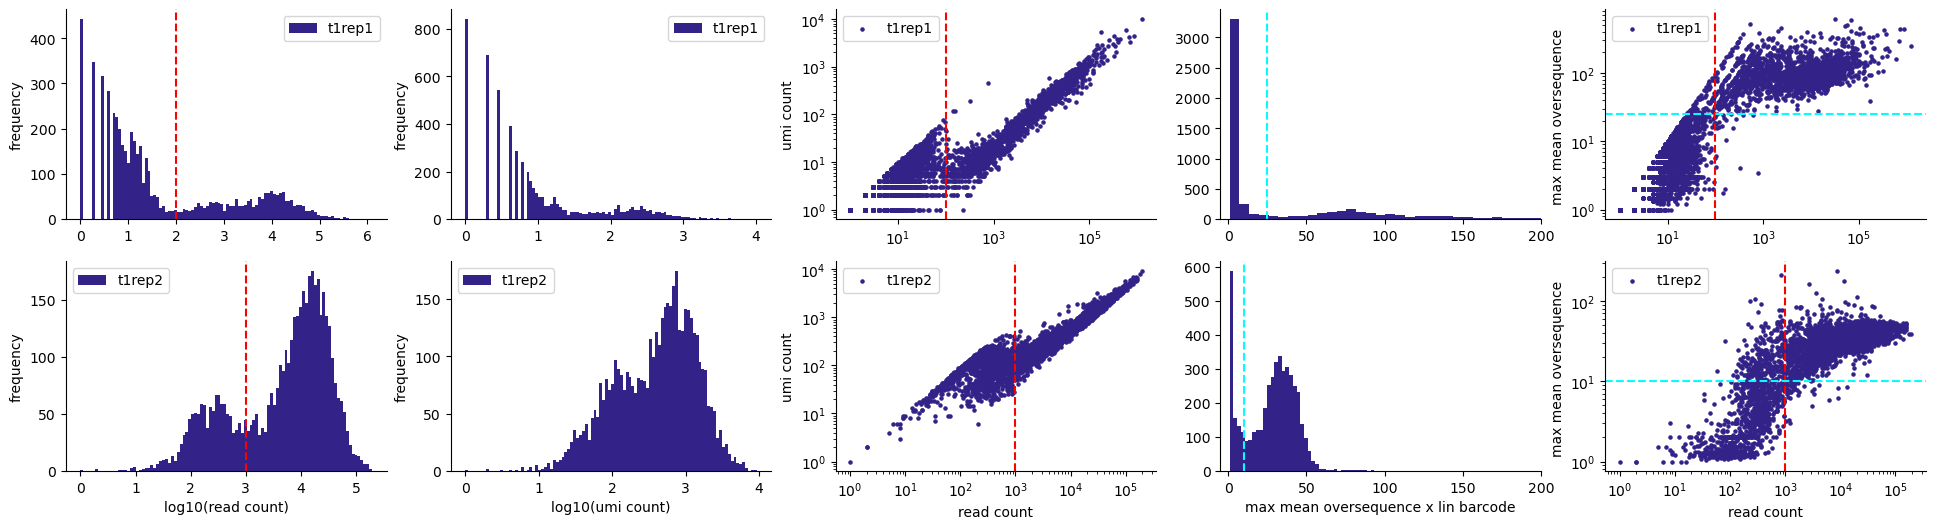

In [24]:
readcount_th = {'t1rep1': 1e2, 't1rep2': 1e3, 't2rep1': 1e2}
os_th = {'t1rep1': 25, 't1rep2': 10, 't2rep1': 20}
line_th = {'t1rep1': {'a': 1e-10, 'b': .95}, 't1rep2': {'a': 1e-6, 'b': .95}, 't2rep1': {'a': 1e-6, 'b': .95}}
strat = 'nested'
fig, axs = plt.subplots(nrows=len(cell_metadata), ncols = 5, figsize = (5*3*1.6, 3*len(cell_metadata)))
for i, (aaxx, time) in enumerate(zip(axs, cell_metadata)):
    ax = aaxx[0]
    ax.hist(np.log10(cell_metadata[time][strat]['read_count']), bins = 100, label = time)
    ax.legend(); ax.axvline(np.log10(readcount_th[time]), c= 'r', ls = '--')
    if i == len(cell_metadata)-1:
        ax.set_xlabel('log10(read count)')
    ax.set_ylabel('frequency')
    
    ax = aaxx[1]
    ax.hist(np.log10(cell_metadata[time][strat]['umi_count']), bins = 100, label = time)
    ax.legend(); ax.set_ylabel('frequency')
    if i == len(cell_metadata)-1:
        ax.set_xlabel('log10(umi count)')
        
    ax = aaxx[2]
    ax.scatter(cell_metadata[time][strat]['read_count'], cell_metadata[time][strat]['umi_count'], s = 5, label =time)
    ax.axvline(readcount_th[time], c= 'r', ls = '--')
    #xra = np.linspace(cell_metadata[time][strat]['read_count'].min(), cell_metadata[time][strat]['read_count'].max(), 100)
    #ax.plot(xra, (10**line_th[time]['a'])*(xra**line_th[time]['b']), c = 'purple', ls = '--')
    ax.legend(); ax.set_ylabel('umi count')
    ax.set_xscale('log'); ax.set_yscale('log'); 
    if i == len(cell_metadata)-1:
        ax.set_xlabel('read count')
        
    ax = aaxx[3]
    ax.hist(cell_metadata[time][strat]['max_overseq'], bins = 100, label = time)
    if i == len(cell_metadata)-1:
        ax.set_xlabel('max mean oversequence x lin barcode')
    ax.set_xlim(-5,200); ax.axvline(os_th[time], c = 'cyan', ls ='--')
    
    ax = aaxx[4]
    ax.scatter(cell_metadata[time][strat]['read_count'], cell_metadata[time][strat]['max_overseq'], s = 5, label =time)
    ax.legend(); ax.set_xscale('log'); ax.set_yscale('log'); ax.set_ylabel('max mean oversequence ')
    ax.axvline(readcount_th[time], c= 'r', ls = '--'); ax.axhline(os_th[time], c = 'cyan', ls ='--')
    if i == len(cell_metadata)-1:
        ax.set_xlabel('read count')
fig.savefig(outdir + '/QCcells_nested.pdf', bbox_inches = 'tight')

In [25]:
! cp ../trackerseq_analysis/QCcells_nested.pdf /Users/cupida/Dropbox/noelle/BROs_2024/paper/

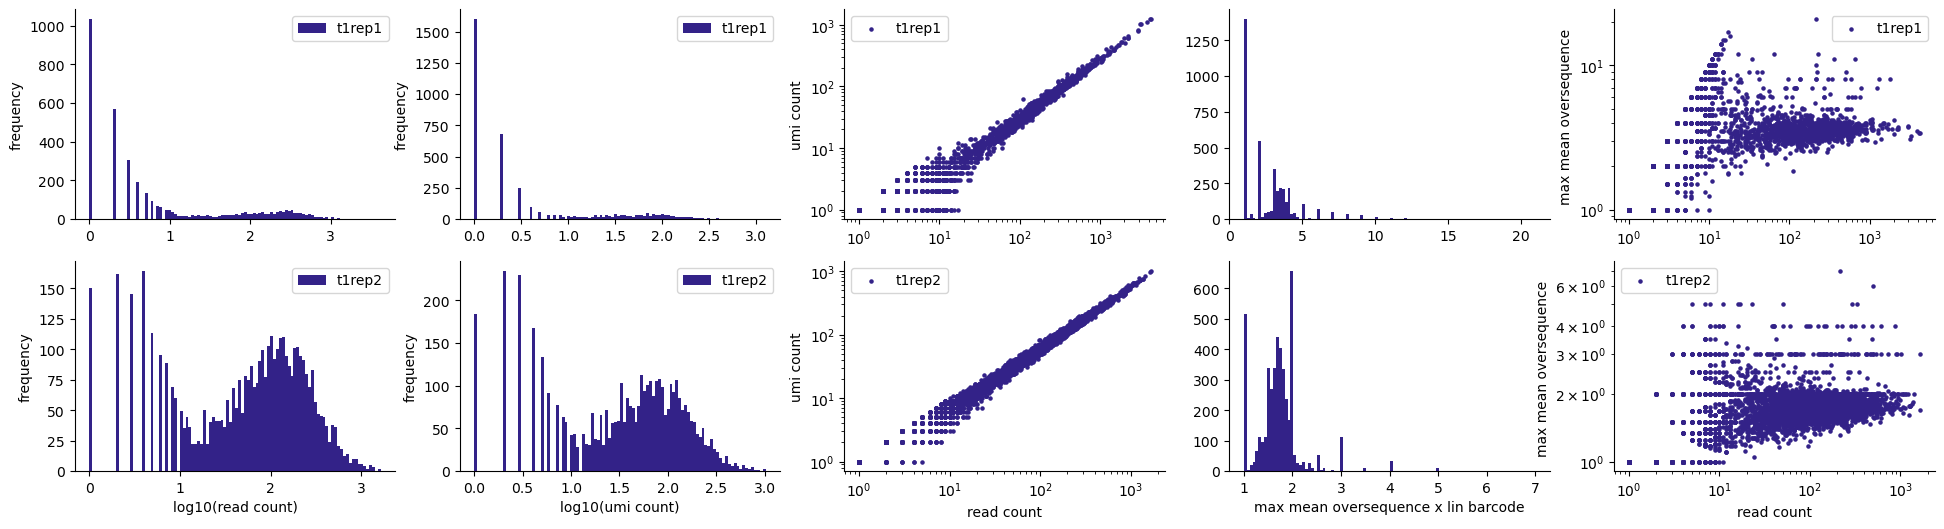

In [26]:
#readcount_th = {'t1rep1': 1e2, 't1rep2': 1e3, 't2rep1': 1e2}
#os_th = {'t1rep1': 25, 't1rep2': 15, 't2rep1': 20}
#line_th = {'t1rep1': {'a': 1e-10, 'b': .95}, 't1rep2': {'a': 1e-6, 'b': .95}, 't2rep1': {'a': 1e-6, 'b': .95}}
strat = 'gex'
fig, axs = plt.subplots(nrows=len(cell_metadata), ncols = 5, figsize = (5*3*1.6, 3*len(cell_metadata)))
for i, (aaxx, time) in enumerate(zip(axs, cell_metadata)):
    ax = aaxx[0]
    ax.hist(np.log10(cell_metadata[time][strat]['read_count']), bins = 100, label = time)
    ax.legend(); 
    #ax.axvline(np.log10(readcount_th[time]), c= 'r', ls = '--')
    if i == len(cell_metadata)-1:
        ax.set_xlabel('log10(read count)')
    ax.set_ylabel('frequency')
    
    ax = aaxx[1]
    ax.hist(np.log10(cell_metadata[time][strat]['umi_count']), bins = 100, label = time)
    ax.legend(); ax.set_ylabel('frequency')
    if i == len(cell_metadata)-1:
        ax.set_xlabel('log10(umi count)')
        
    ax = aaxx[2]
    ax.scatter(cell_metadata[time][strat]['read_count'], cell_metadata[time][strat]['umi_count'], s = 5, label =time)
    #ax.axvline(readcount_th[time], c= 'r', ls = '--')
    #xra = np.linspace(cell_metadata[time][strat]['read_count'].min(), cell_metadata[time][strat]['read_count'].max(), 100)
    #ax.plot(xra, (10**line_th[time]['a'])*(xra**line_th[time]['b']), c = 'purple', ls = '--')
    ax.legend(); ax.set_ylabel('umi count')
    ax.set_xscale('log'); ax.set_yscale('log'); 
    if i == len(cell_metadata)-1:
        ax.set_xlabel('read count')
        
    ax = aaxx[3]
    ax.hist(cell_metadata[time][strat]['max_overseq'], bins = 100, label = time)
    if i == len(cell_metadata)-1:
        ax.set_xlabel('max mean oversequence x lin barcode')
    #ax.set_xlim(-5,200); 
    #ax.axvline(os_th[time], c = 'cyan', ls ='--')
    
    ax = aaxx[4]
    ax.scatter(cell_metadata[time][strat]['read_count'], cell_metadata[time][strat]['max_overseq'], s = 5, label =time)
    ax.legend(); ax.set_xscale('log'); ax.set_yscale('log'); ax.set_ylabel('max mean oversequence ')
    #ax.axvline(readcount_th[time], c= 'r', ls = '--'); ax.axhline(os_th[time], c = 'cyan', ls ='--')
    if i == len(cell_metadata)-1:
        ax.set_xlabel('read count')

In [27]:
flin_coutc = {}; flin_coutb = {}; flin_umi = {}
for time in lindata_coutc:
    cellstokeep = cell_metadata[time]['nested'][cell_metadata[time]['nested']['read_count']>readcount_th[time]].index
    flin_coutc[time] = lindata_coutc[time]['nested'][cellstokeep]
    linstokeep = flin_coutc[time].index[flin_coutc[time].sum(axis=1)>0]
    flin_coutc[time] = flin_coutc[time].loc[linstokeep]
    flin_coutb[time] = lindata_coutb[time]['nested'].loc[linstokeep,cellstokeep]
    flin_umi[time] = lindata_umi[time]['nested'].loc[linstokeep,cellstokeep]
    print(time, lindata_coutc[time]['nested'].shape, flin_coutc[time].shape)

t1rep1 (7851, 5457) (7806, 1704)
t1rep2 (5328, 4661) (5315, 3470)


In [28]:
flin_umi[time]

,AAACCCAAGAGCACTG,AAACCCAGTACACGCC,AAACCCATCTTTGCTA,AAACGAACATGGTACT,AAACGAATCCATGAGT,AAACGCTAGCAGATAT,AAACGCTAGTCGCGAA,AAACGCTCAACCAATC,AAACGCTCATAATCGC,AAACGCTTCAGCCTCT,...,TTTGATCAGCCTTCTC,TTTGATCCATAGATGA,TTTGATCGTCTTGAAC,TTTGATCTCTTGGGCG,TTTGGAGGTCATACCA,TTTGGTTCAAGTGGAC,TTTGTTGAGCTCTGTA,TTTGTTGAGTCGGCCT,TTTGTTGCAGCGTATT,TTTGTTGGTGCCCGTA
TTGTTGCGGTGAGAGC,"{'AAAACAATGGTT': 2, 'AAAAGATATCTT': 11, 'AAAAG...","{'AAAAGCCACACC': 169, 'AAACAGTTGCTA': 1, 'AAAC...","{'AAAACCCACACT': 6, 'AAACATCTGATC': 10, 'AAATT...","{'AAATCGACAGCA': 1, 'AACAATTGGTGG': 1, 'AACAGG...","{'AAAAATGGATCC': 1, 'AAAACTATCGGG': 1, 'AAAACT...","{'AAAAATCTAGGA': 1, 'AAAAATCTAGGT': 195, 'AAAA...","{'AAACTTAACAAA': 1, 'AAAGCAACGGCC': 1, 'AAATTC...","{'AAAATACCTTCA': 1, 'AAAATCCTCACC': 1, 'AAACCC...","{'AAAACATGACGC': 80, 'AAAAGACTCACA': 285, 'AAA...","{'AAAACCGCCACA': 3, 'AAAACCTAGCCG': 166, 'AAAA...",...,"{'AAAACAACTACG': 2, 'AAAACCACGTGA': 166, 'AAAC...","{'AAAAGCTAGACT': 1, 'AAGGAGACGCCA': 1, 'AAGGTG...","{'AAGGGTCGCGGG': 1, 'AAGTGTAAGCGC': 1, 'AATCCA...","{'AAAAAAGGGCTG': 5, 'AAACCGTTACCG': 1, 'AAAGAG...","{'AAAACTAAATTT': 1, 'AACATTCCAAGC': 4, 'AAGCTT...","{'AAACAATACGTC': 1, 'AAAGTATCTTTC': 1, 'AACATC...","{'AAGGTATTGTCC': 5, 'AAGTTCCAATTT': 1, 'AATGTT...","{'AAAACACAGAAG': 1, 'AAATTACAGGTT': 42, 'AAGCA...","{'AAAACCGACGAT': 4, 'AAAATTGTAACC': 1, 'AAACAT...","{'AAAAGCTTGCGG': 141, 'AAACCAATAGGT': 1, 'AAAG..."
AGCGTGACTTCCGGGG,"{'AAAAGCCTCGCT': 1, 'AAAATGCAGCCG': 1, 'AAACAA...","{'AAAAGCCACACC': 4, 'AAAAGCCCCGCA': 1, 'AAACCC...","{'AAAACCAACACT': 1, 'AAAACCCACACT': 167, 'AAAC...","{'AAAGGTGGGGCA': 1, 'AACAGGTTGTGT': 1, 'AACATG...","{'AAAACTGGATCC': 2, 'AAACGGACGTTG': 1, 'AAAGAA...","{'AAAAATCTAGGT': 5, 'AAAAGAGGGTTG': 4, 'AAACAC...","{'AAAGCCCTAGCG': 2, 'AAATTCGTAAAC': 2, 'AACCGA...","{'AAACCCTTGCGC': 3, 'AAATATCACGAG': 4, 'AAATCA...","{'AAAACATGACGC': 3, 'AAAAGACTCACA': 4, 'AAACCC...","{'AAAACCTAGCCG': 2, 'AAACATGTCCAA': 1, 'AAACGC...",...,"{'AAAACCACGTGA': 5, 'AAAACTCGTTGG': 1, 'AAACCG...","{'AAGCATAGCCTA': 2, 'AAGGTGACAGTA': 1, 'AAGGTG...","{'AAATGGGGGAAA': 1, 'AAGCTAAGAGTC': 2, 'AATGAA...","{'AAAAAAGGGCTG': 2, 'AACCGGCATACT': 1, 'AAGTAC...","{'AACATGGCATGC': 1, 'AACATTCAAAGC': 1, 'AACATT...","{'AAACAATACGTC': 1, 'AAAGGGTACAGT': 1, 'AATGTC...","{'AAATACGCGACT': 2, 'AAGGTATTGTCC': 170, 'AAGG...","{'AACTTCTATACA': 1, 'AAGGTAACAGCT': 9, 'AATAAT...","{'AAAACCGACGAT': 73, 'AAACATGTTGGG': 127, 'AAA...","{'AAAAGCTTGCGG': 2, 'AAAGCTGAATTG': 4, 'AAATAA..."
GGGGTGGCTTATTGAA,"{'AGCTGAGTTACG': 1, 'CAGCCGGGTACA': 1, 'CCGACT...","{'CAACGTTCCCTC': 1, 'CAGCACGCGACT': 2, 'CTAGAC...","{'AATATATAGTCG': 1, 'CATGCTGAAACT': 1, 'CCGGGT...","{'ATAAATTTCGCA': 1, 'ATTAAGGTTCTA': 1, 'GACTTT...","{'AAAGAACTCTAC': 1, 'GATACGGAACAT': 1}","{'ATACGAGTCCTT': 1, 'ATATGACAGCAA': 1, 'CAAGAA...","{'AACCGTAGTACA': 1, 'CGTGTTATGCAG': 1, 'CTGCCG...","{'AGAGGACACTAC': 1, 'AGCGCAATTTAA': 1, 'AGCTCT...","{'ATAATTCCGCTA': 1, 'CACAACAGGTGT': 1, 'CTTGTG...","{'AACGCGGGTGGG': 1, 'AAGCACATGATT': 1, 'AATTTC...",...,"{'AAACTTCGCAAT': 1, 'ATCATACTGTTG': 1, 'GCCCGG...",{'CACTCGCTGAGG': 1},NaN,"{'AGGCCGACACTG': 1, 'AGGTATGGTCAC': 1, 'TCTGTA...","{'CCGTCTGTAAAA': 1, 'CCTTTTGGGCTA': 1}",{'TTCTGGTGTGCA': 1},NaN,"{'ACACATAACGGT': 1, 'ATCAGAGACAGA': 1, 'GCTATT...","{'AATACAAATTCT': 1, 'ACAGTTTTCCCG': 1, 'ACATGT...","{'AACGTTTCAGGT': 1, 'ATCGCAGCCAGG': 1, 'GATGGG..."
TTAAGTGTGCGCTGGA,"{'CAAAATAGGTAA': 1, 'CACACGCGCCAG': 1, 'GGGGCG...","{'ATGTATGATATT': 2, 'GCACAGTGTTCC': 1, 'TCACTT...","{'GGCCCCCACCTA': 1, 'GTGAAACTCAGG': 2, 'TATTCT...","{'GGTTGAATTGGA': 1, 'TTGAAGTGGTTT': 2}",{'AGGGGCTGTTAT': 1},"{'CTCTTTTTCCAT': 1, 'CTTTTAATCTCT': 1, 'GGTTTG...","{'ACAAGTAGCTCC': 1, 'AGGCTCATCTGG': 1, 'CACCAG...","{'AAAGTAAACCCT': 2, 'AAGGACATATCT': 1, 'ACACGA...","{'ACGCAATCAAAA': 1, 'AGCGCCGACGGG': 1, 'ATAACT...","{'AATTTCTCCGGT': 1, 'AGACGGATTTTG': 1, 'AGCGAA...",...,"{'GTCAACTGCTGT': 2, 'TCAGTTCAGGTC': 1}","{'CGGTAGACCCAT': 1, 'GTATTGTTCTGA': 1, 'TGACAC...",{'CGAAAGCCTGCG': 1},NaN,{'ACTTCATATTTT': 1},NaN,{'ATACGAACACCT'

# QC on barcodes

In [29]:
def hamming(s1, s2):
    n = sum([l1!=l2 for l1, l2 in zip(s1, s2)])
    return n

In [30]:
def lineage_metadata(umidf, coutcdf):
    overseq = pd.Series({idx: [] for idx in umidf.index})
    for idx in umidf.index:
        for x in umidf.loc[idx]:
            if type(x) == dict:
                overseq.loc[idx] += list(x.values())
    odf = pd.DataFrame({'mean_overseq': overseq.apply(lambda x: np.mean(x)), 
                        'std_overseq': overseq.apply(lambda x: np.std(x)),
                        'max_overseq': overseq.apply(lambda x: np.max(x)),
                        'num_cells': (coutcdf>0).sum(axis=1)})
    odf = odf.loc[overseq.index]
    return odf

In [31]:
linbarcode_metadata = {time: lineage_metadata(flin_umi[time], flin_coutc[time]) for time in flin_umi}


In [32]:
linbarcode_metadata

{'t1rep1':                   mean_overseq  std_overseq  max_overseq  num_cells
 CTCATTGTCGTTGAAT    119.687564   752.941795        61070       1410
 TCGTGGATGTCCGATC    158.447252  1176.499162        54540        793
 TGGCGAGCGGGGCGTT     93.405928   488.976479        30652        797
 GATGACCTTTTGGCAT     89.933513   626.894112        51950        924
 GGATTCGTCTTTAAGC    134.803564   910.201832        31945        623
 ...                        ...          ...          ...        ...
 CATGGTCATTTAGGTC      1.000000     0.000000            1          1
 CATGTGCCGTTATGGC      1.000000     0.000000            1          1
 CATTGGCCTTTCGCGC      1.000000     0.000000            1          1
 CCTTTATGTCGGAGAT      1.000000     0.000000            1          1
 GTTTTTGGAGGCGAGG      1.000000     0.000000            1          1
 
 [7806 rows x 4 columns],
 't1rep2':                   mean_overseq  std_overseq  max_overseq  num_cells
 TTGTTGCGGTGAGAGC     26.837381    58.786659          8

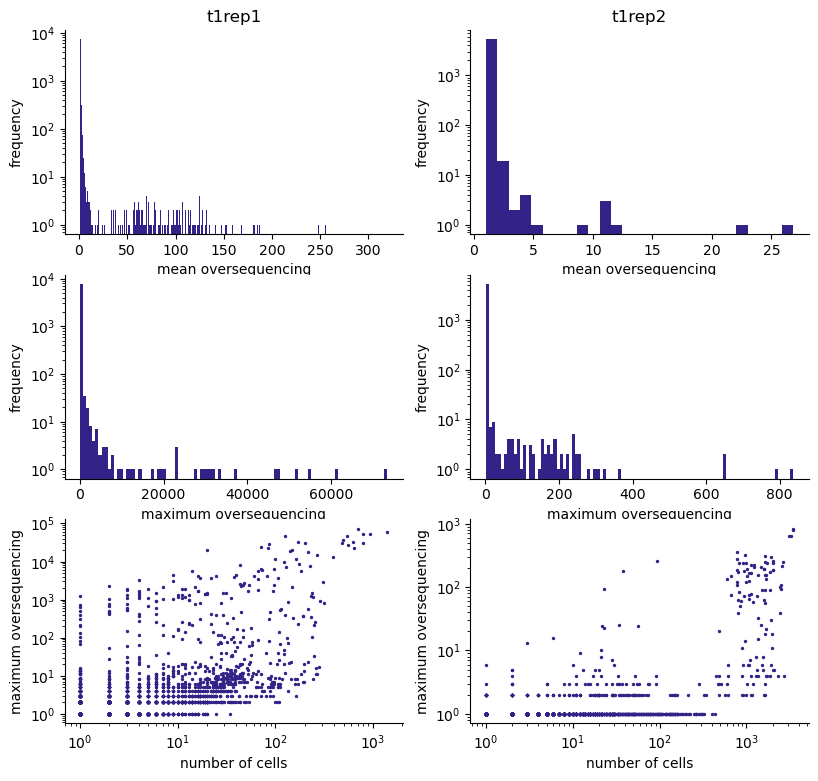

In [33]:
fig, maxs = plt.subplots(ncols = len(linbarcode_metadata), nrows = 3, figsize = (3*len(linbarcode_metadata)*1.6, 3*3))

axs = maxs[0]
for ax, time in zip(axs, linbarcode_metadata):
    ax.hist(linbarcode_metadata[time]['mean_overseq'], bins = int(linbarcode_metadata[time]['mean_overseq'].max())+1)
    #ax.hist(flin_metadata[time]['mean_overseq'], bins = 100, alpha =0.5)
    ax.set_title(time); ax.set_yscale('log')
    ax.set_xlabel('mean oversequencing')
    ax.set_ylabel('frequency')
    
axs = maxs[1]
for ax, time in zip(axs, linbarcode_metadata):
    ax.hist(linbarcode_metadata[time]['max_overseq'], bins = 100)
    #ax.hist(flin_metadata[time]['mean_overseq'], bins = 100, alpha =0.5)
    ax.set_yscale('log')
    ax.set_xlabel('maximum oversequencing')
    ax.set_ylabel('frequency')
    
axs = maxs[2]
for ax, time in zip(axs, linbarcode_metadata):
    ax.scatter(linbarcode_metadata[time]['num_cells'], linbarcode_metadata[time]['max_overseq'], s = 2)
    ax.set_xlabel('number of cells'); ax.set_ylabel('maximum oversequencing')
    ax.set_xscale('log'); ax.set_yscale('log')

In [34]:
flin_metadata = {}
for time in linbarcode_metadata:
    flin_metadata[time] = linbarcode_metadata[time][~((linbarcode_metadata[time]['num_cells']==1)&(linbarcode_metadata[time]['max_overseq']==1))]
#    flin_metadata[time] = flin_metadata[time].sort_values(by='mean_overseq', ascending=False)
    print(time, linbarcode_metadata[time].shape, flin_metadata[time].shape)

t1rep1 (7806, 4) (3348, 4)
t1rep2 (5315, 4) (2483, 4)


In [35]:
flin_metadata

{'t1rep1':                   mean_overseq  std_overseq  max_overseq  num_cells
 CTCATTGTCGTTGAAT    119.687564   752.941795        61070       1410
 TCGTGGATGTCCGATC    158.447252  1176.499162        54540        793
 TGGCGAGCGGGGCGTT     93.405928   488.976479        30652        797
 GATGACCTTTTGGCAT     89.933513   626.894112        51950        924
 GGATTCGTCTTTAAGC    134.803564   910.201832        31945        623
 ...                        ...          ...          ...        ...
 GACCATGTTCGGGCAT      1.000000     0.000000            1          2
 AGGCCAACTATAGAAC      1.000000     0.000000            1          2
 CGGTCCGGTATGGCAT      2.000000     0.000000            2          1
 GTGAGTGAAGCGTAGA      1.000000     0.000000            1          2
 AGGCCAACTAAATAAC      1.000000     0.000000            1          2
 
 [3348 rows x 4 columns],
 't1rep2':                   mean_overseq  std_overseq  max_overseq  num_cells
 TTGTTGCGGTGAGAGC     26.837381    58.786659          8

In [36]:
for time in flin_metadata:
    flin_coutc[time] = flin_coutc[time].loc[flin_metadata[time].index]
    flin_coutb[time] = flin_coutb[time].loc[flin_metadata[time].index]
    flin_umi[time] = flin_umi[time].loc[flin_metadata[time].index]
    
    df = 100*flin_coutb[time]/flin_coutb[time].sum()
    flin_metadata[time]['max_coutbfrac'] = df.max(axis=1)
    df = 100*flin_coutc[time]/flin_coutc[time].sum()
    flin_metadata[time]['max_coutcfrac'] = df.max(axis=1)

/var/folders/ht/4c6cf6y13c356khd1r0vtqxh0000gn/T/ipykernel_68816/358711087.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flin_metadata[time]['max_coutbfrac'] = df.max(axis=1)
/var/folders/ht/4c6cf6y13c356khd1r0vtqxh0000gn/T/ipykernel_68816/358711087.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flin_metadata[time]['max_coutcfrac'] = df.max(axis=1)
/var/folders/ht/4c6cf6y13c356khd1r0vtqxh0000gn/T/ipykernel_68816/358711087.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [37]:
for time in flin_metadata:
    idx_pool = []
    hd_idx = pd.Series()
    for idx in flin_metadata[time].index:
        if len(idx_pool)==0:
            idx_pool += [idx]
            hd_idx.loc[idx] = len(idx)
        else:
            hds = [hamming(idx,idx0) for idx0 in idx_pool]
            idx_pool += [idx]
            hd_idx.loc[idx] = np.min(hds)
    flin_metadata[time]['Hamming'] = hd_idx.loc[flin_metadata[time].index]

/var/folders/ht/4c6cf6y13c356khd1r0vtqxh0000gn/T/ipykernel_68816/2596017462.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flin_metadata[time]['Hamming'] = hd_idx.loc[flin_metadata[time].index]
/var/folders/ht/4c6cf6y13c356khd1r0vtqxh0000gn/T/ipykernel_68816/2596017462.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flin_metadata[time]['Hamming'] = hd_idx.loc[flin_metadata[time].index]


In [38]:
flin_metadata['t1rep2'].sort_values(by='max_overseq', ascending=False).head(30)

,mean_overseq,std_overseq,max_overseq,num_cells,max_coutbfrac,max_coutcfrac,Hamming
TTGTTGCGGTGAGAGC,26.837381,58.786659,837,3470,87.164430,96.964095,16
AGCGTGACTTCCGGGG,22.277696,51.312164,793,3470,83.954155,95.933522,11
GGGGTGGCTTATTGAA,10.791021,37.239759,650,3241,34.557596,92.212684,8
TTAAGTGTGCGCTGGA,10.625556,39.574785,647,3125,25.096525,81.863186,11
TGGGCTAGGGGGGTTT,11.867442,37.343226,362,774,29.128015,90.069620,9
GGTTCTTCTTTTGGGT,8.677324,30.222043,320,968,41.031390,90.922604,8
TCGTTGCGGTGAGAGC,1.412592,7.266719,307,1635,2.000000,1.598492,1
AGTGTGACTTCCGGGG,1.411361,3.415421,298,1900,3.883495,0.655096,1
GATCAATATACTCATT,4.353716,22.656688,279,775,30.805687,75.663601,10
TTGTCGCGGTGAGAGC,1.638266,5.648793,255,2053,1.754386,1.024462,1


In [39]:
flin_metadata['t1rep1'].sort_values(by='max_overseq', ascending=False).head(50)

,mean_overseq,std_overseq,max_overseq,num_cells,max_coutbfrac,max_coutcfrac,Hamming
CATGGGCCTTTCGGGC,125.387482,979.951344,73532,708,100.000000,100.000000,8
CTCATTGTCGTTGAAT,119.687564,752.941795,61070,1410,100.000000,100.000000,16
TCGTGGATGTCCGATC,158.447252,1176.499162,54540,793,86.666667,99.613039,13
GATGACCTTTTGGCAT,89.933513,626.894112,51950,924,100.000000,100.000000,11
CGGTCCGGTAAACACG,96.885052,746.611344,47231,542,100.000000,100.000000,10
CGTGGAGTTATGGGCC,106.993080,1272.895990,46441,126,76.666667,99.410858,7
TCTTTATGTAGGAGAT,130.618304,712.000750,37238,495,82.352941,99.796196,7
TGTAGGTTTAGATAGC,184.807768,1466.527527,33274,172,82.539683,99.642963,10
GGATTCGTCTTTAAGC,134.803564,910.201832,31945,623,100.000000,100.000000,9
AACACCCCTGCCGGCG,128.156002,849.284176,31501,487,100.000000,100.000000,9


In [40]:
#flin_metadata['t2rep1'].sort_values(by='max_overseq', ascending=False).head(30)

In [41]:
# time = 't1rep2'
# flin_metadata[time][(flin_metadata[time]['max_coutbfrac']>10)&(flin_metadata[time]['max_coutcfrac']>10)]

In [42]:
# flin_metadata[time][flin_metadata[time]['Hamming']>2]

In [43]:
fflin_metadata = {}
fflin_coutb = {}
fflin_coutc = {}
fflin_umi = {}
for time in flin_metadata:
    fflin_metadata[time] = flin_metadata[time][(flin_metadata[time]['max_coutbfrac']>10)&(flin_metadata[time]['max_coutcfrac']>10)]
    fflin_coutc[time] = flin_coutc[time].loc[fflin_metadata[time].index]
    fflin_coutb[time] = flin_coutb[time].loc[fflin_metadata[time].index]
    fflin_umi[time] = flin_umi[time].loc[fflin_metadata[time].index]
    print(time, flin_metadata[time].shape, fflin_metadata[time].shape)

t1rep1 (3348, 7) (118, 7)
t1rep2 (2483, 7) (8, 7)


In [44]:
fflin_coutc[time].sum()

AAACCCAAGAGCACTG    30841
AAACCCAGTACACGCC    17655
AAACCCATCTTTGCTA    19861
AAACGAACATGGTACT    16974
AAACGAATCCATGAGT     4645
                    ...  
TTTGGTTCAAGTGGAC     2118
TTTGTTGAGCTCTGTA     2346
TTTGTTGAGTCGGCCT    17193
TTTGTTGCAGCGTATT    44887
TTTGTTGGTGCCCGTA    11122
Length: 3470, dtype: int64

# Filter with single cell resolution

In [45]:
# def second_text(x):
#     """Input: column of coutb or coutc table"""
#     sdf = x[x>0].sort_values(ascending=False)
#     if len(sdf) == 1:
#         bc = sdf.index[0]; bc_counts = {bc: sdf.loc[bc]}; pooled_bc = {bc: []}; hdf = []
#     else:
#         hdf = pd.DataFrame({idx1: {idx2: hamming(idx1, idx2) for idx2 in sdf.index} for idx1 in sdf.index})
#         bc = sdf.index[0]; bc_counts = {bc: sdf.loc[bc]}; pooled_bc = {bc: []}
#         for idx in sdf.index[1:]:
#             if not np.any([hdf.loc[idx,b]<4 for b in bc.rsplit('-')]):
#                 bc = bc + '-' + idx
#                 bc_counts[idx] = sdf.loc[idx]
#                 pooled_bc[idx] = []
#             else:
#                 ref_bc = hdf.loc[idx,[b for b in bc.rsplit('-')]].sort_values().index[0]
#                 bc_counts[ref_bc] += sdf.loc[idx]
#                 pooled_bc[ref_bc] += [idx]
#     return bc_counts, pooled_bc, hdf, sdf
# #        sdf = pd.Series(bc_counts)
# #        count_th = sdf.loc[[idx not in bc.rsplit('-') for idx in sdf.index]].max() if sum([idx not in bc.rsplit('-') for idx in sdf.index])!=0 else 0
# #        sdf = sdf.loc[bc.rsplit('-')]
# #        sdf = sdf[sdf>count_th]
# #        if len(sdf) == 1:
# #            bc = sdf.index[0]
# #            zdf = pd.Series({bc: 0.1})
# #        else:
# #            n = sdf.sum()
# #            rdf = pd.DataFrame({i: Counter(np.random.choice(sdf.index, size = sdf.sum())) for i in range(1000)})
# #            #zdf = pd.Series({l: zscore([sdf.loc[l]] + list(rdf.loc[l].values[:10]))[0] for l in sdf.index})
# #            zdf = pd.Series({idx: ((rdf.loc[idx] > sdf.loc[idx]).sum())/1000+0.1 for idx in sdf.index})
# #    return zdf

In [46]:
consensus_barcode = {}
counts_barcode = {}
bc_evidence = {}
for time in fflin_umi:
    print(time)
    consensus_barcode[time] = {}
    counts_barcode[time] = {}
    bc_evidence[time] = {}
    for i in range(len(fflin_umi[time].columns)):
        x = fflin_umi[time][fflin_umi[time].columns[i]]
        sdf = x[x.apply(lambda x: type(x)==dict)] # selects all lineage barcodes in which there are reads
        v0max_odf = sdf.apply(lambda x: sorted(x.values())[::-1][0]).sort_values(ascending=False) # sorts based on lineage oversequencing rate
        max_odf = v0max_odf[v0max_odf/v0max_odf.sum()>0.2] # removes barcodes whose maximum overseqeuncing is too little as compared to the rest
        sdf = sdf.loc[max_odf.index]
        if len(sdf) == 0:
            bc = '-'
        elif len(sdf)==1:
            bc = sdf.index[0]
            fmax_odf = max_odf
        else:
#            print()
#            print(i)
#            print(max_odf)
            hdf = pd.DataFrame({idx1: {idx2: hamming(idx1, idx2) for idx2 in sdf.index} for idx1 in sdf.index})
            bc = max_odf.index[0]
            for idx in sdf.index[1:]:
                if not np.any([hdf.loc[idx,b]<4 for b in bc.rsplit('-')]):
                    bc = bc + '-' + idx
            fmax_odf = max_odf.loc[bc.rsplit('-')] 
#            print(fmax_odf)
            filt_fmax_odf = fmax_odf[fmax_odf/fmax_odf.sum()>(1./len(fmax_odf)-(1./len(fmax_odf))**2)] # multinomial
#            if len(filt_fmax_odf) != len(fmax_odf):
#                print(filt_fmax_odf)
#                break
            counts_barcode[time][i] = dict(filt_fmax_odf)
            bc = '-'.join(sorted(filt_fmax_odf.index))
        try:
            bc_evidence[time][bc][fmax_odf.name] = dict(v0max_odf)
        except:
            bc_evidence[time][bc] = {fmax_odf.name: dict(v0max_odf)}
        consensus_barcode[time][flin_umi[time].columns[i]] = bc # barcode assignation per cell
    for bc in bc_evidence[time]:
        bc_evidence[time][bc] = pd.DataFrame(bc_evidence[time][bc]).fillna(0).astype(int)

t1rep1
t1rep2


In [47]:
# bc_evidence['t1rep1']['GGATTCGTCTTTAAGC'].loc[['GGATTCGTCTTTAAGC','GTGAGTGATGCGTCGA']]

In [48]:
# lindata_coutb['t1rep1']['nested'].loc[['GGATTCGTCTTTAAGC','GTGAGTGATGCGTCGA'],bc_evidence['t1rep1']['GGATTCGTCTTTAAGC'].columns]

In [49]:
# bc_evidence['t1rep1']['GTGAGTGATGCGTCGA'].loc[['GGATTCGTCTTTAAGC','GTGAGTGATGCGTCGA']]

In [50]:
# lindata_coutb['t1rep1']['nested'].loc[['GGATTCGTCTTTAAGC','GTGAGTGATGCGTCGA'],bc_evidence['t1rep1']['GGATTCGTCTTTAAGC-GTGAGTGATGCGTCGA'].columns]

In [51]:
# bc_evidence['t1rep1']['GGATTCGTCTTTAAGC-GTGAGTGATGCGTCGA'].head()

In [52]:
Counter(consensus_barcode['t1rep1'].values())

Counter({'CTCATTGTCGTTGAAT': 411,
         'GATGACCTTTTGGCAT': 181,
         'TGGCGAGCGGGGCGTT': 157,
         'CATGGGCCTTTCGGGC': 86,
         'TCGTGGATGTCCGATC': 78,
         'TCTTTATGTAGGAGAT': 66,
         'CGGTCCGGTAAACACG': 66,
         'AACACCCCTGCCGGCG': 46,
         'TTCTCGTATAGGCGCT': 42,
         'CCAAAGGCGTGGTCAC': 33,
         'GGTATTTAATCCGATC': 30,
         'CCCGTGTCCGTATTGC': 28,
         'AATCTTGTTCTAGTGT': 23,
         'GGGTCCCCTACACGCT': 22,
         'GGATTCGTCTTTAAGC-GTGAGTGATGCGTCGA': 21,
         'GGATTCGTCTTTAAGC': 20,
         'TCGGCAAATGGAGTTT': 19,
         'GTGAGTGATGCGTCGA': 18,
         'ACACACTCTTCAAAAA': 17,
         'CGGTCCGGTAAACACG-GTTAGCCAACCTGTTG': 15,
         'TGTAGGTTTAGATAGC': 14,
         'GTCAGGGGCTTTGTTT': 14,
         'AGCGTCAAGATGCTGG': 14,
         'AGGAGAGGGGGAGGCG': 11,
         'CGGCTCACGTTTTAGG': 10,
         'CGTGGAGTTATGGGCC': 10,
         'GTTAGCCAACCTGTTG': 9,
         'CAGAAACGCTAAAACG': 8,
         'AGGGAGGAGGTGATGG': 7,
         

In [53]:
#https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259
#https://networkx.org/documentation/latest/auto_examples/drawing/plot_knuth_miles.html#sphx-glr-auto-examples-drawing-plot-knuth-miles-py

In [54]:
import networkx as nx
import itertools as it
from mycolorpy import colorlist as mcp

In [55]:
cnt = Counter(consensus_barcode['t1rep1'].values())

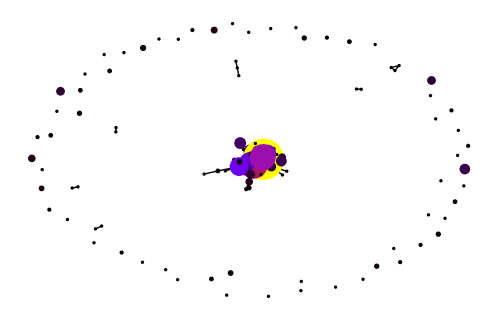

In [56]:
G = nx.Graph()

nodes = set()
for barcodes in cnt:
    for barcode in barcodes.rsplit('-'):
        if len(barcode)>0:
            nodes.add(barcode)

for node in nodes:
    if node in cnt:
        G.add_node(node, size = cnt[node])
    else:
        G.add_node(node, size = 1)

for barcodes in cnt:
    if len(barcodes.rsplit('-'))>1 and len(barcodes)>1:
        for pair in it.combinations(barcodes.rsplit('-'), 2):
            G.add_edge(pair[0], pair[1], weight = cnt[barcodes])

color2=mcp.gen_color(cmap="gnuplot",n=cnt.most_common(1)[0][-1])

nx.draw(
    G,
    node_size=[2*G.nodes[n]['size'] for n in G.nodes],
    node_color=[color2[G.nodes[n]['size']-1] for n in G.nodes],
    #with_labels=True, font_size=6
)

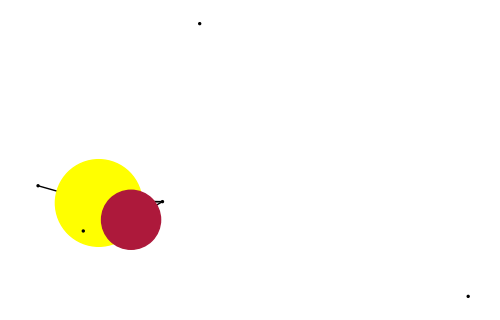

In [57]:
cnt = Counter(consensus_barcode['t1rep2'].values())

G = nx.Graph()

nodes = set()
for barcodes in cnt:
    for barcode in barcodes.rsplit('-'):
        if len(barcode)>0:
            nodes.add(barcode)

for node in nodes:
    if node in cnt:
        G.add_node(node, size = cnt[node])
    else:
        G.add_node(node, size = 1)

for barcodes in cnt:
    if len(barcodes.rsplit('-'))>1 and len(barcodes)>1:
        for pair in it.combinations(barcodes.rsplit('-'), 2):
            G.add_edge(pair[0], pair[1], weight = cnt[barcodes])

color2=mcp.gen_color(cmap="gnuplot",n=cnt.most_common(1)[0][-1])

nx.draw(
    G,
    node_size=[2*G.nodes[n]['size'] for n in G.nodes],
    node_color=[color2[G.nodes[n]['size']-1] for n in G.nodes],
    #with_labels=True, font_size=6
)

In [58]:
for time in consensus_barcode:
    pd.Series(consensus_barcode[time]).to_csv(outdir + '/linbarcodes_'+time+'.tsv', sep = '\t')



In [ ]:
###############
STOP HERE!!!!!!
###############

# Exploration in GEX

In [ ]:
#adata = sc.read_h5ad('./t1t2_untreated/merged_all_GEX_analyzed.h5ad')

In [ ]:
#adata.obs

In [ ]:
# consensus_barcode['t1rep1'] = pd.Series(consensus_barcode['t1rep1'])
# consensus_barcode['t1rep1'].index = [idx + "_rep1_t1" for idx in consensus_barcode['t1rep1'].index]

In [ ]:
# consensus_barcode['t1rep2'] = pd.Series(consensus_barcode['t1rep2'])
# consensus_barcode['t1rep2'].index = [idx + "_rep2_t1" for idx in consensus_barcode['t1rep2'].index]

In [ ]:
# consensus_barcode['t2rep1'] = pd.Series(consensus_barcode['t2rep1'])
# consensus_barcode['t2rep1'].index = [idx + "_rep1_t2" for idx in consensus_barcode['t2rep1'].index]

In [ ]:
# all_consensus_barcode = pd.concat([consensus_barcode['t1rep1'],consensus_barcode['t1rep2'],consensus_barcode['t2rep1']])

In [ ]:
# all_consensus_barcode.to_csv('/Users/cupida/Dropbox/noelle/BROs/lineages_barcodes_231109.tsv', sep = '\t')

In [ ]:
# adata.obs['lineage'] = [all_consensus_barcode.loc[idx] +'_' +adata.obs.loc[idx,'sample'] if idx in all_consensus_barcode.index else '-' for idx in adata.obs.index ]

In [ ]:
# clones = pd.Series(Counter(adata.obs['lineage']))
# clones.index.name = 'cell_number'
# clones = pd.DataFrame(clones)
# clones['sample'] = ['_'.join(cl.rsplit('_')[1:]) for cl in clones.index]

In [ ]:
# clones

In [ ]:
# udf_nils.tail()

In [ ]:
# # udf_nils = read_csv('Nils/261023metadata_nils.csv', index_col = 0)

# udf_nils.index = [
#     idx.rsplit('_')[-1].rsplit('-')[0] + '_H9-1' if udf_nils.loc[idx,'t1.meta.data.sample'] == 'EDisUntrNoTra_1' else
#     idx.rsplit('_')[-1].rsplit('-')[0] + '_H9-2' if udf_nils.loc[idx,'t1.meta.data.sample'] == 'EDisUntrNoTra_2' else
#     idx.rsplit('_')[-1].rsplit('-')[0] + '_IPS-1' if udf_nils.loc[idx,'t1.meta.data.sample'] == 'IDisUntrNoTra_1' else    idx.rsplit('-')[0].rsplit('_')[1] + '_rep1_t1' if udf_nils.loc[idx,'t1.meta.data.sample'] == 'A0251' else
#     idx.rsplit('-')[0].rsplit('_')[1] + '_rep1_t1' if udf_nils.loc[idx,'t1.meta.data.sample'] == 'A0256' else
#     idx.rsplit('-')[0].rsplit('_')[1] + '_rep1_t1' if udf_nils.loc[idx,'t1.meta.data.sample'] == 'A0257' else
#     idx.rsplit('-')[0].rsplit('_')[1] + '_rep1_t1' if udf_nils.loc[idx,'t1.meta.data.sample'] == 'A0258' else
#     idx.rsplit('-')[0].rsplit('_')[1] + '_rep1_t1' if udf_nils.loc[idx,'t1.meta.data.sample'] == 'A0254' else
#     idx.rsplit('-')[0].rsplit('_')[1] + '_rep1_t1' if udf_nils.loc[idx,'t1.meta.data.sample'] == 'A0260' else
#     idx.rsplit('-')[0].rsplit('_')[1] + '_rep1_t1' if udf_nils.loc[idx,'t1.meta.data.sample'] == 'A0262' else
#     idx.rsplit('-')[0].rsplit('_')[1] + '_rep1_t1' if udf_nils.loc[idx,'t1.meta.data.sample'] == 'A0264' else
#     idx.rsplit('_')[-1].rsplit('-')[0]+ '_rep2_t1' if udf_nils.loc[idx,'t1.meta.data.sample'] == 'T1-2-H9-1' else
#     idx for idx in udf_nils.index
# ]

# sample2sample = {
#     'T1-2-H9-1': 'T1_2_H9_1',
#     'A0251': 'H9_WT1-1',
#     'A0256': 'H9_1', 
#     'A0257': 'H9_2',
#     'A0258': 'H9_3',
#     'A0254': 'IPS_WT1',
#     'A0260': 'IPS_1',
#     'A0262': 'IPS_2',
#     'A0264': 'IPS_4'   
# }

# udf_nils['sample'] = [sample2sample[udf_nils.loc[idx,'t1.meta.data.sample']] if udf_nils.loc[idx,'t1.meta.data.sample'] in sample2sample else udf_nils.loc[idx,'t1.meta.data.sample'] for idx in udf_nils.index]

# udf_nils['u1'] = udf_nils['runid.umap_1']
# udf_nils['u2'] = udf_nils['runid.umap_2']

# udf_nils['lineage'] = [adata.obs.loc[idx,'lineage'] if idx in adata.obs.index else '-' for idx in udf_nils.index]

In [ ]:
# pd.crosstab(udf_nils['t1.meta.data.sample'], udf_nils['sample'])

```
	gene_name	type
gene_id		
H9_WT1	A0251	Antibody Capture
H9_1	A0256	Antibody Capture
H9_2	A0257	Antibody Capture
H9_3	A0258	Antibody Capture
IPS_WT1	A0254	Antibody Capture
IPS_1	A0260	Antibody Capture
IPS_2	A0262	Antibody Capture
IPS_4	A0264	Antibody Capture
```

In [ ]:
# udf_nils

In [ ]:
# udf = pd.DataFrame(adata.obsm['X_umap'], columns = ['u1','u2'], index = adata.obs.index)
# for j, sample in enumerate(set(clones['sample'])):
#     if len(sample)>0:
#         for cl in clones[(clones['sample']==sample)&(clones[0]>4)].index:
#             if cl != '-':
#                 fig, axs = plt.subplots(ncols = 4, figsize = (4*3*1.6,3))
#                 ax = axs[1]
#                 cells = adata.obs[adata.obs['lineage']==cl].index
#                 ax.scatter(udf['u1'], udf['u2'], s= 1, c = 'silver')
#                 ax.scatter(udf.loc[cells,'u1'], udf.loc[cells,'u2'], s = 1)
#                 ax.set_xticks([]); ax.set_yticks([])
#                 ax.set_title(cl)
#                 ax = axs[0]
#                 sample = '_'.join(cl.rsplit('_')[1:])
#                 cells = adata.obs[adata.obs['sample']==sample].index
#                 ax.scatter(udf['u1'], udf['u2'], s= 1, c = 'silver')
#                 ax.scatter(udf.loc[cells,'u1'], udf.loc[cells,'u2'], s = 1, c = Colors.colors[j])
#                 ax.set_xticks([]); ax.set_yticks([])
#                 ax.set_title(sample)
#                 ax = axs[2]
#                 cells = udf_nils[udf_nils['sample']==sample].index
#                 ax.scatter(udf_nils['u1'], udf_nils['u2'], s= 1, c = 'silver')
#                 ax.scatter(udf_nils.loc[cells,'u1'], udf_nils.loc[cells,'u2'], s = 1, c = Colors.colors[j])
#                 ax.set_xticks([]); ax.set_yticks([]); ax.set_title(sample)
#                 ax = axs[3]
#                 cells = udf_nils[udf_nils['lineage']==cl].index
#                 ax.scatter(udf_nils['u1'], udf_nils['u2'], s= 1, c = 'silver')
#                 ax.scatter(udf_nils.loc[cells,'u1'], udf_nils.loc[cells,'u2'], s = 1)
#                 ax.set_xticks([]); ax.set_yticks([]); ax.set_title(cl)

In [ ]:
# for clustercol in ['t1.meta.data.RNA_snn_res.0.4','t1.meta.data.RNA_snn_res.0.8','t1.meta.data.RNA_snn_res.1.2']:
#     cdf = pd.crosstab(udf_nils['t1.meta.data.RNA_snn_res.0.4'], udf_nils['sample'])
#     fig, ax = plt.subplots(figsize = (3*3*1.6, 3))
#     for i, sample in enumerate(cdf.columns):
#         ax.bar(np.arange(len(cdf))+i*1/(1+len(cdf.columns)), cdf[sample], width = 1/(1+len(cdf.columns)), label = sample)
#         ax.legend(loc = 2, bbox_to_anchor = (1,1))
#         ax.set_title(clustercol)
#         ax.set_xticks(np.arange(len(cdf))); ax.set_xticklabels(np.arange(len(cdf)))

In [ ]:
# for clustercol in ['t1.meta.data.RNA_snn_res.0.4','t1.meta.data.RNA_snn_res.0.8','t1.meta.data.RNA_snn_res.1.2']:
#     cdf = pd.crosstab(udf_nils['t1.meta.data.RNA_snn_res.0.4'], udf_nils['sample'])
#     cdf = 100*cdf/cdf.sum()
#     fig, ax = plt.subplots(figsize = (3*3*1.6, 3))
#     for i, sample in enumerate(cdf.columns):
#         ax.bar(np.arange(len(cdf))+i*1/(1+len(cdf.columns)), cdf[sample], width = 1/(1+len(cdf.columns)), label = sample)
#         ax.legend(loc = 2, bbox_to_anchor = (1,1))
#         ax.set_title(clustercol)
#         ax.set_xticks(np.arange(len(cdf))); ax.set_xticklabels(np.arange(len(cdf)))

In [ ]:
# sc.pl.umap(adata, color = ['AQP4','AQP1','GFAP','ANXA2','CRABP1','STMN2','NHLH1','SOX2','NRXN3'])

In [ ]:
# udf_nils

In [ ]:
# nadata = adata.copy()
# nadata = nadata[[idx in udf_nils.index for idx in nadata.obs.index],:]
# nadata.shape, adata.shape

In [ ]:
# nadata.obsm['X_umap'] = np.array(udf_nils.loc[nadata.obs.index,['u1','u2']])

In [ ]:
# sc.pl.umap(nadata, color = ['AQP4','AQP1','GFAP','ANXA2','CRABP1','STMN2','NHLH1','SOX2','NRXN3'])

In [ ]:
# sc.pl.umap(adata, color = ['AQP4','AQP1','GFAP','ANXA2','CRABP1','STMN2','NHLH1','SOX2','NRXN3'])

In [ ]:
# Counter(udf_nils.loc[[idx for idx in udf_nils.index if idx not in adata.obs.index],'t1.meta.data.sample'])

In [ ]:
# udf_nils.loc['GACTCAATCGGCATTA_H9-1']

In [ ]:
# nadata.obsm['X_umap'] = np.array(udf_nils)

In [ ]:
# sc.pl.umap(adata, color = ['cell_line'])

In [ ]:
# Counter(udf_nils['sample'])

# QC on barcodes

In [ ]:
cell = fcoutb['rep1']['gex'].columns[6]
test1 = second_text(fcoutb['rep1']['gex'][cell])
test2 = second_text(fcoutb['rep1']['nested'][cell])


In [ ]:
test1[0]

In [ ]:
test2[0]

In [ ]:
ffcoutb = {expt: {c: pd.DataFrame() for c in fcoutb[expt]} for expt in fcoutb}
for expt in ffcoutb:
    for c in ffcoutb[expt]:
        pandarallel.initialize()
        ffcoutb[expt][c] = pd.DataFrame(dict(fcoutb[expt][c].parallel_apply(lambda x: second_text(x)[0])))
        ffcoutb[expt][c] = ffcoutb[expt][c].fillna(0).astype(int)



# Compare nested and GEX

In [ ]:
expt = 'rep1'
ffcoutb[expt]['gex']

In [ ]:
expt = 'rep1'
ffcoutb[expt]['nested']

In [ ]:
for expt in ffcoutb:
    for c in ffcoutb[expt]:
        print(expt, c)
        print(ffcoutb[expt][c].shape)
        for cell in ffcoutb[expt][c].columns[:20]:
            print(cell, ':', Counter(dict(ffcoutb[expt][c][cell][ffcoutb[expt][c][cell]>0])).most_common())
        print()
    

In [ ]:
def get_lineage_barcode(col_df):
    sdf = col_df[col_df>0].sort_values(ascending=False)
    if len(sdf)==1:
        zdf = sdf
    else:
        n = sdf.sum()
        rdf = pd.DataFrame({i: Counter(np.random.choice(sdf.index, size = sdf.sum())) for i in range(1000)})
        rdf = rdf.loc[sdf.index]
        zdf = sdf-(rdf.mean(axis=1)-rdf.std(axis=1))
    return '-'.join(zdf[zdf>0].index)


In [ ]:
ffcoutb['rep1']['nested'][ffcoutb['rep1']['nested'].columns[:10]].apply(lambda x: get_lineage_barcode(x))

In [ ]:
bc = {}
for expt in ffcoutb:
    bc[expt] = {}
    for c in ffcoutb[expt]:
        pandarallel.initialize()
        bc[expt][c] = ffcoutb[expt][c].parallel_apply(lambda x: get_lineage_barcode(x))

In [ ]:
Counter(bc['rep2']['gex'])

In [ ]:
Counter(bc['rep2']['nested'])

# Projection in the transcriptome data

In [ ]:
! gunzip merged_GEX_analyzed.h5ad.gz

In [ ]:
tx = sc.read_h5ad('merged_GEX_analyzed.h5ad')

In [ ]:
sc.pl.umap(tx)

In [ ]:
for expt in bc: 
    for c in bc[expt]:
        bc[expt][c].index = [c + '_' + expt for c in bc[expt][c].index]

In [ ]:
bc_rep1 = pd.concat([bc['rep1']['gex'], bc['rep2']['gex']])

In [ ]:
tx.obs['lineage'] = [bc_rep1.loc[idx] if idx in bc_rep1.index else '-' for idx in tx.obs.index]

In [ ]:
tx.obs['linage_sample'] = [tx.obs.loc[idx,'lineage'] + '-' + tx.obs.loc[idx,'sample'] if tx.obs.loc[idx,'lineage'] != '-' else '-' for idx in tx.obs.index]

In [ ]:
tx.obs['linage_sample']

In [ ]:
lineages = Counter(tx.obs['linage_sample'])
lineages = Counter({c: lineages[c] for c in lineages if c != '-' and lineages[c] > 4 })

In [ ]:
lineages.most_common()

In [ ]:
udf = pd.DataFrame(tx.obsm['X_umap'], columns = ['u1','u2'], index = tx.obs.index)
fig, maxs = plt.subplots(ncols = 5, nrows = 7, figsize = (3*5*1.6, 7*3))
axs = maxs.reshape(5*7)
for ax,lin in zip(axs,lineages):
    ax.scatter(udf['u1'], udf['u2'], s = 1, c = 'silver')
    cells = tx.obs[tx.obs['linage_sample']==lin].index
    sudf = udf.loc[cells]
    ax.scatter(sudf['u1'], sudf['u2'], s = 1, c = 'red')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(lin, fontsize = 8)

In [ ]:
sc.pl.umap(tx, color = 'sample')

In [ ]:
lineages

In [ ]:
bc['rep2']['gex']

In [ ]:
bc['rep2']['gex'].to_csv('lineageGEX_barcodes_t1rep2.csv', sep = '\t')
bc['rep1']['gex'].to_csv('lineageGEX_barcodes_t1rep1.csv', sep = '\t')

In [ ]:
bc['rep1']['nested'].to_csv('lineageNESTED_barcodes_t1rep1.csv', sep = '\t')
bc['rep2']['nested'].to_csv('lineageNESTED_barcodes_t1rep2.csv', sep = '\t')